In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData, Column, Integer, String, inspect

In [4]:
import sqlite3
from pathlib import Path

In [5]:
# create engine to hawaii.sqlite
database_path = Path("hawaii.sqlite")
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()
#sqlite3.connect(f"sqlite:///{database_path}")

In [6]:
#establishing MetaData to contain all of the Schema constructs
metadata = MetaData()

In [7]:
# reflect an existing database into a new model
Base = automap_base(metadata.reflect(engine))
#Base = automap_base() Also works

# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#Show list of columns in table, station
Base.metadata.tables['station'].columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [12]:
#Show list of columns in table and the designated types for measurement
inspector=inspect(engine)
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

# Exploratory Precipitation Analysis

In [13]:
#Count the number of entries in databse
total_entries = session.query((Measurement.date)).count()
print(f"There are {total_entries} total entries")

# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).first()
print(f"Most recent date is: {recent_date}")

There are 19550 total entries
Most recent date is: ('2017-08-23',)


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_year_entries = session.query(Measurement).filter(Measurement.date > '2016-08-23').count()
#print(f'There are {recent_year_entries} entries in the last 12 months')

# Calculate the date one year from the last date in data set.
most_recent_dt = dt.datetime.strptime(recent_date[0],'%Y-%m-%d')
year_from_recent_dt = dt.date(most_recent_dt.year - 1, most_recent_dt.month, most_recent_dt.day)
year_from_recent_dt

# Perform a query to retrieve the data and precipitation scores
measurement_table = [Measurement.date,Measurement.prcp]
measurement_query = session.query(*measurement_table).filter(Measurement.date >= year_from_recent_dt).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_db = pd.DataFrame(measurement_query,columns=['Date','Precipitation'])
prcp_db = prcp_db.dropna()

# Sort the dataframe by date
prcp_db = prcp_db.sort_values(['Date'],ascending=True)

#Group by Date to see total Precipitation per day
prcp_date = prcp_db.groupby('Date').sum()
prcp_date

,Precipitation
Date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


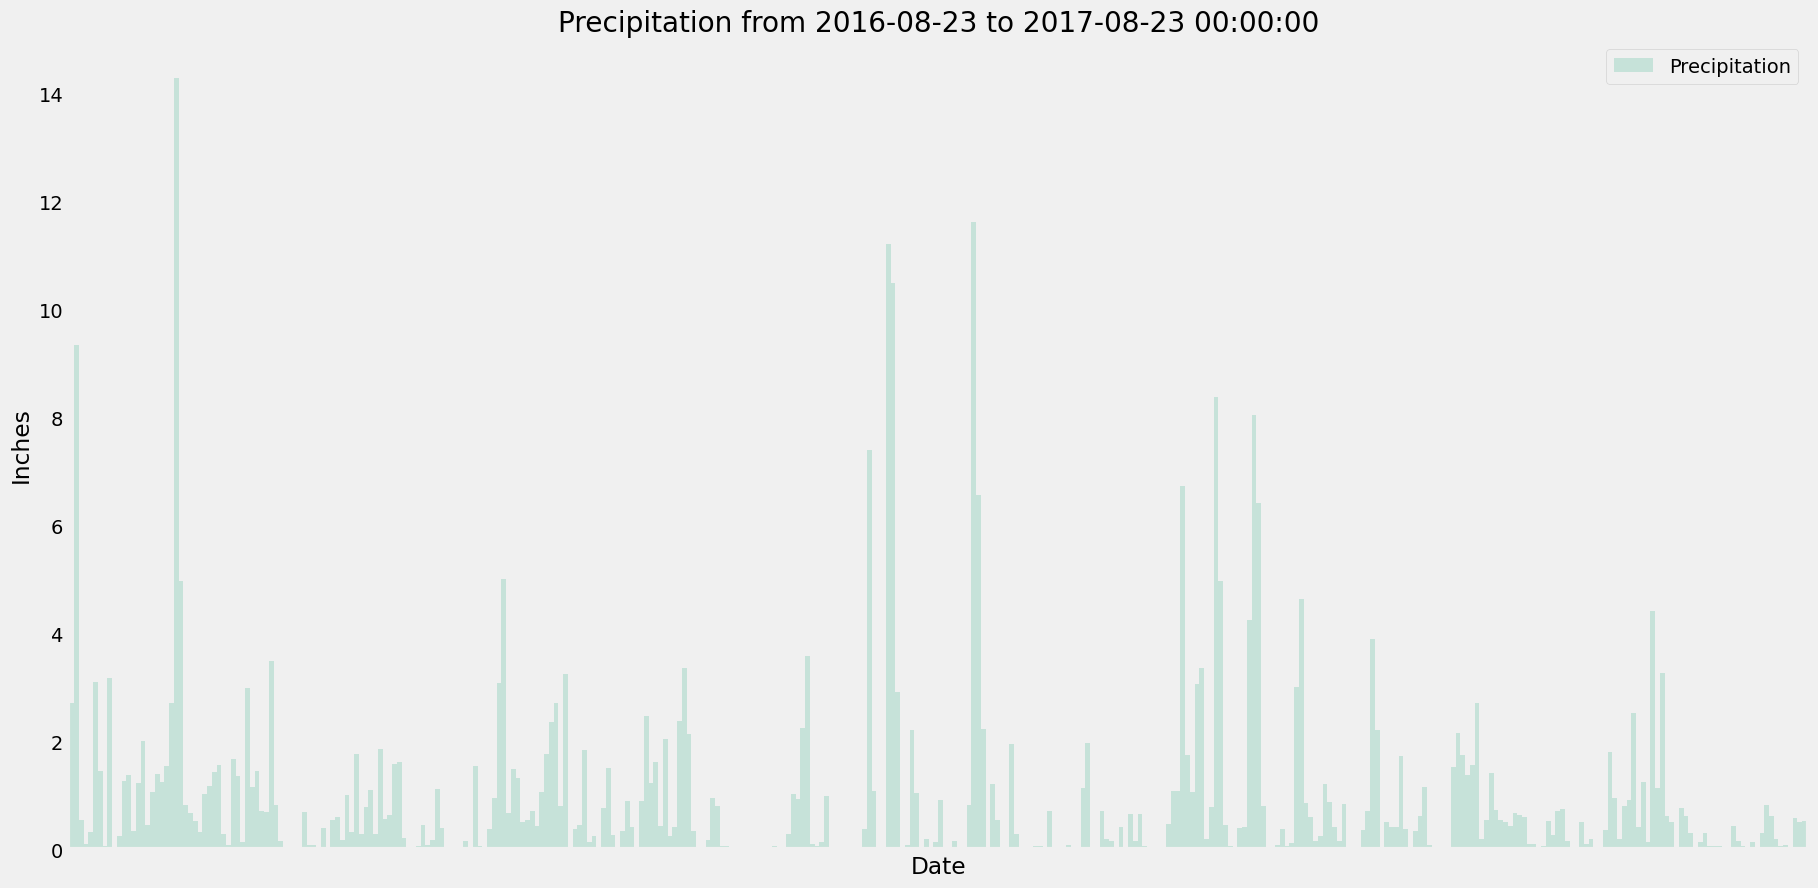

In [30]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_date.plot(kind='bar',
            colormap='Set2',
            figsize=(20,10),
              width=1,
              alpha=0.3)
plt.tick_params(axis='x',
                which='major', 
                labelsize=10,
               labelbottom=False)

plt.tick_params(axis='x',
                which='major',
                labelsize=10)

plt.title(f'Precipitation from {year_from_recent_dt} to {most_recent_dt}') #graph title
plt.xlabel('Date') #label x axis
plt.ylabel('Inches') #Label y axis
plt.grid(visible=None, which='both') #Removing the grid lines
plt.savefig("Images/Precipitation Graph from 2016-08-23 to 2017-08-23.png") #Save graph as png
plt.show()
#plt.figure(facecolor="white") #meant to change background of graph but doesnt work well with SQL 

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_db.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
#'id', 'station', 'name', 'latitude', 'longitude', 'elevation'
station_table = [Station.id, 
                 Station.station, 
                 Station.name,
                 Station.latitude,
                 Station.longitude,
                 Station.elevation]
station_query = session.query(*station_table).all()
station_db = pd.DataFrame(station_query,columns=['ID',
                                                 'Station',
                                                 'Name',
                                                 'Latitude',
                                                 'Longitude',
                                                 'Elevation'])

session.query(Station.id).count()

#Pandas method same result
#station_db['Station'].count()

9

In [18]:
station_db

,ID,Station,Name,Latitude,Longitude,Elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

#Utilizing Queries and pandas to provide list of stations and the number of entries
#Creating a query and database for viewing the full dataset
measurement_expanded_table = [Measurement.id,
                              Measurement.station,
                              Measurement.date,
                              Measurement.prcp,
                              Measurement.tobs
                             ]
measurement_expanded_query = session.query(*measurement_expanded_table).all()

measurement_db = pd.DataFrame(measurement_expanded_query,columns=['ID',
                                                 'Station',
                                                 'Date',
                                                 'Percipitation',
                                                 'Tobs',
                                                 ])

#Creaing a query and database for only Measurement.id and Measurement.station
#Results in a cleaner table and no need to delete unnecessary columns
measurement_station_table = [Measurement.id,
                            Measurement.station]
measurement_station_query = session.query(*measurement_station_table).all()

measurement_stations_db = pd.DataFrame(measurement_station_query,columns=['ID',
                                                                          'Station' 
                                                                         ])
active_stations_db = measurement_stations_db.groupby(['Station']).count().sort_values(['ID'],ascending=False)
active_stations_db

#Utilizing Sqlalchmey functionality
active_stations_table = [Measurement.station,func.count(Measurement.id)]
active_stations_query = session.query(*active_stations_table).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.id).desc()).all()
active_stations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_measurement = func.min(Measurement.tobs)
max_measurement = func.max(Measurement.tobs)
mean_measurement = func.avg(Measurement.tobs)

statistics_stations_table = [min_measurement,
                             max_measurement,
                             mean_measurement,
                             #Measurement.station, #will introduce additional columns
                             #func.count(Measurement.id) #not needed
                            ]
statistics_query = session.query(*statistics_stations_table).group_by(Measurement.station).\
                           order_by(func.count(Measurement.id).desc()).first()
statistics_query

(54.0, 85.0, 71.66378066378067)

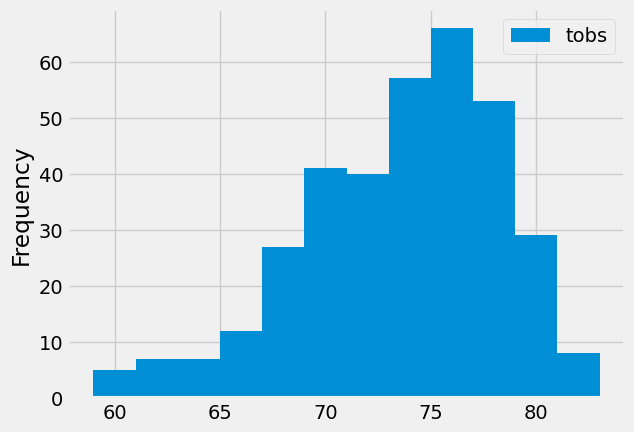

In [29]:
# Using the most active station id
active_stations_id = active_stations_query[0][0]

# Query the last 12 months of temperature observation data for this station
measurement_date_tobs = [Measurement.date, Measurement.tobs]
active_stations_obs = session.query(*measurement_date_tobs).\
                            filter(Measurement.date >= year_from_recent_dt).\
                            filter(Measurement.date <= most_recent_dt).\
                            filter(Measurement.station == active_stations_id).all()

#Convert Query to Database
active_station_db = pd.DataFrame(active_stations_obs)

#Plot the results as a histogram
active_station_db.plot.hist(bins=12, rwidth=1.0)
plt.savefig("Images/Temperature Observations from 2016-08-23 to 2017-08-23.png") #Save graph as png
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()